# Regression and Other Stories: Arsenic
Building a logistic regression model: wells in Bangladesh. See Chapter 13 in Regression and Other Stories.

In [1]:
import arviz as az
from bambi import Model, Prior
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
from scipy import stats, special
import statsmodels.formula.api as smf

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
wells = pd.read_csv("https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Arsenic/data/wells.csv")
wells.head()

,switch,arsenic,dist,dist100,assoc,educ,educ4
0,1,2.36,16.826000,0.16826,0,0,0.0
1,1,0.71,47.321999,0.47322,0,0,0.0
2,0,2.07,20.966999,0.20967,0,10,2.5
3,1,1.15,21.486000,0.21486,0,12,3.0
4,1,1.10,40.874001,0.40874,1,14,3.5


In [3]:
n = wells.shape[0]
n

3020

# Null model
## Log-score for coin flipping

In [4]:
prob = .5
np.round(np.log(prob)*(wells["switch"].sum()) + np.log(1-prob)*(1-wells["switch"]).sum(),1)

-2093.3

## Log-score for intercept model

In [5]:
prob = wells["switch"].mean()
np.round(prob,2)

0.58

In [6]:
np.round(np.log(prob)*(wells["switch"].sum()) + np.log(1-prob)*(1-wells["switch"]).sum(),1)

-2059.0

# A single predictor

In [11]:
model = Model(wells)
fit_1 = model.fit('switch ~ dist', family='bernoulli', link="logit", samples=1000, chains=4)

/opt/conda/lib/python3.8/site-packages/bambi/models.py:267: UserWarning: Modeling the probability that switch=='1'
  warnings.warn(
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dist, Intercept]
INFO:pymc3:NUTS: [dist, Intercept]


RuntimeError: Chain 0 failed.

#### Use PyMC3 directly for now to get around chain failure

In [14]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('switch ~ dist',
                            wells,
                            family=pm.glm.families.Binomial())
    trace = pm.sample(1000, tune=1000, init='adapt_diag')

    fit_1 = az.from_pymc3(trace=trace)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dist, Intercept]
INFO:pymc3:NUTS: [dist, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The acceptance probability does not match the target. It is 0.8801136691881247, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6739049562765321, but should be close to 0.8. Try to increase the number of tuning steps.


In [16]:
func_dict = {"Median": np.median,
        "MAD_SD":stats.median_abs_deviation,
         }
coefs = az.summary(fit_1, stat_funcs=func_dict, extend=False, round_to=2)
coefs

,Median,MAD_SD
Intercept,0.61,0.04
dist,-0.01,0.00


## LOO log score

In [17]:
az.loo(fit_1)

Computed from 4000 by 3020 log-likelihood matrix

         Estimate       SE
elpd_loo -2040.15    10.45
p_loo        2.02        -

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

## Histogram of distances

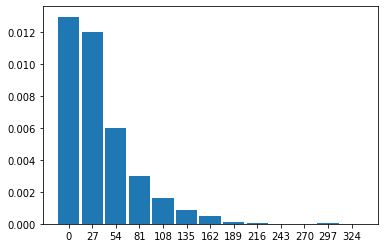

In [19]:
fig, ax = plt.subplots()
az.plot_dist(wells["dist"], kind="hist")

## Histogram of distances